In [22]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append("..")
from PhysicsDatasets import DampedSHODatasetV2
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import json
from matplotlib.colors import LogNorm, Normalize
import utils
import os
from datetime import datetime
import yaml
import re
from tqdm import tqdm
import plotting as ptools
device = 'cuda' if torch.cuda.is_available() else ('mps' if torch.backends.mps.is_available() else 'cpu')

base_dir = "../trainings/"

from matplotlib.colors import Normalize
from matplotlib.colorbar import ColorbarBase
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
from matplotlib.animation import FuncAnimation, PillowWriter
from scipy.optimize import curve_fit

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Extrapolate $\omega_0$ low to high

In [24]:
model = "tokenized_continuousW0Beta_wLo_betaAll"
best_model, iter_models, iter_ckpts, config, model_dir = ptools.load_all_models(model,base_dir=base_dir)
dt = config['dataset_params']['dt']
seq_len = config['dataset_params']['seq_len']
tokenizer = utils.RealNumberTokenizer(config['model_params']['vocab_size'], config['training_params']['range_limit_tok'])
plot_dir = f"plots/{model}"
os.makedirs(plot_dir,exist_ok=True)

w0s = np.arange(0.1,6.1,0.1)
beta = 1
mask_id = (w0s<=2.0)
mask_ood = (w0s>2.0)

In [25]:
num_per = 100
inpt = []
target = []
for w0 in w0s:
    dset = DampedSHODatasetV2(beta=beta,w0=w0,dt=dt,seq_len=seq_len)
    i,t = dset.sample(num_per,tokenizer=tokenizer)
    inpt.append(i)
    target.append(t)
inpt = torch.cat(inpt,dim=0)
target = torch.cat(target,dim=0)

losses = {}
with torch.no_grad():
    for i_it in tqdm(iter_ckpts):
        iter_models[i_it] = iter_models[i_it].to(device)
        pred = iter_models[i_it](inpt.to(device)).to('cpu')
        losses[i_it]= F.cross_entropy(pred.reshape(-1,pred.size(-1)),target.reshape(-1),reduction='none').view(-1,target.size(-1)).numpy()
        iter_models[i_it] = iter_models[i_it].to('cpu')

for i_it in iter_ckpts:
    losses[i_it] = losses[i_it].reshape(-1,num_per,seq_len-1).mean(axis=1)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:27<00:00,  1.36s/it]


In [43]:
test_i = inpt.numpy().reshape(len(w0s),num_per,-1)
test_o = target.numpy().reshape(len(w0s),num_per,-1)

In [62]:
iw = 29
i = test_i[iw,:1,:]
t = test_o[iw,:1,:]

with torch.no_grad():
    p = iter_models[20000](torch.tensor(i.reshape(1,-1))).cpu()
    lp = F.cross_entropy(p.reshape(-1,p.size(-1)),torch.tensor(t).reshape(-1),reduction='none').view(-1,t.shape[-1])

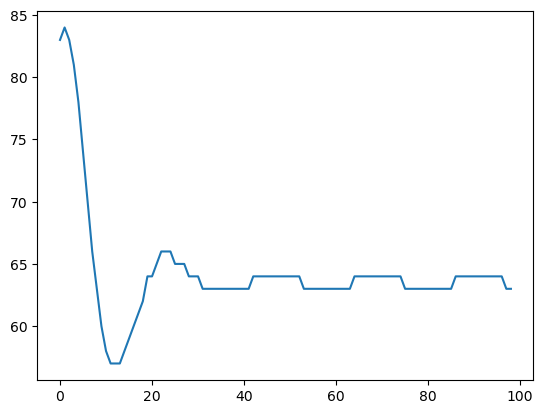

In [65]:
time = np.arange(100)
plt.plot(time[:-1],i[0,:])

/var/folders/l6/xpd37x8x5md3j2v6qz37ptrc0000gn/T/ipykernel_43240/355626420.py:39: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


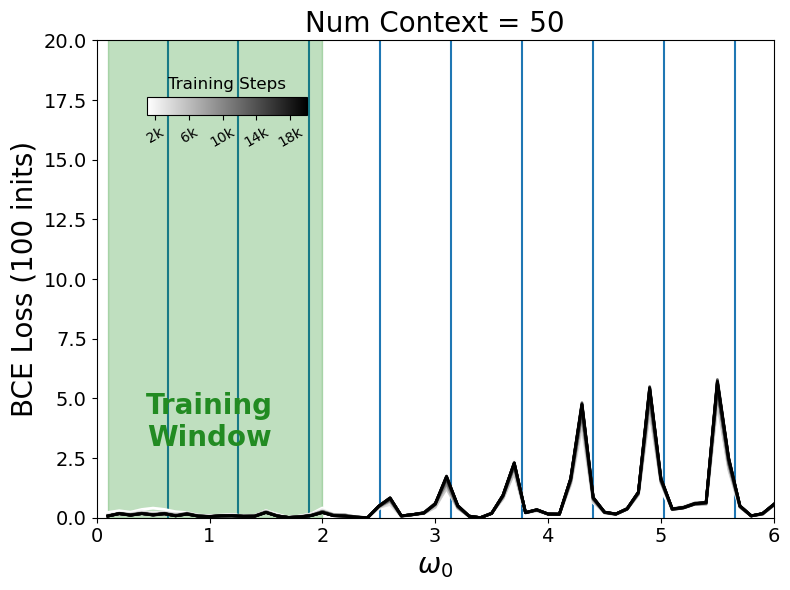

In [40]:
fig = plt.figure(figsize=(8,6))
ax = plt.gca()
cmap = plt.get_cmap("Greys")
colors = [cmap(i/(len(iter_ckpts)-1)) for i in range(len(iter_ckpts))]

n_ctx = 50
lines = []
for i,ck in enumerate(iter_ckpts):
    line, = plt.plot(w0s,losses[ck][:,n_ctx-1],color=colors[i],zorder=1,lw=2)
    lines.append(line)

vert_lines = []
time_context = (n_ctx)*dt
vert_line_Ns = np.arange(1,16)
for n in vert_line_Ns:
    l = plt.axvline(np.pi*(n)/time_context,zorder=0)
    vert_lines.append(l)
    
plt.title(f"Num Context = {n_ctx}",fontsize=20)
plt.fill_betweenx([0,25],[0.1,0.1],[2,2],color='green',alpha=0.25,zorder=0)
#plt.yscale('log')
plt.ylim([0,20])
plt.xlim([0,w0s[-1]])
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel(r"$\omega_0$",fontsize=20)
plt.ylabel(f"BCE Loss ({num_per} inits)",fontsize=20)
plt.text(1,3,"Training\nWindow",horizontalalignment='center',fontsize=20,fontweight='bold',color='forestgreen')

# Add a custom colorbar on top
cbar_ax = fig.add_axes([0.19, 0.8, 0.2, 0.03])  # [left, bottom, width, height]
norm = Normalize(vmin=iter_ckpts[0], vmax=iter_ckpts[-1])
cbar = ColorbarBase(cbar_ax, cmap='binary', norm=norm, orientation='horizontal')
# Customize the colorbar
cbar_ax.set_title("Training Steps", fontsize=12,zorder=1)  # Title for the colorbar
cbar_ax.set_xticks(ticks=iter_ckpts[1::4],labels=[f"{k}" if k < 1000 else f"{k//1000}k" for k in iter_ckpts[1::4]])
cbar_ax.tick_params(labelsize=10,rotation=30)

plt.tight_layout()
plt.savefig(f"{plot_dir}/loss_byW0_stepsOverlay_ctx{n_ctx}.png")
plt.savefig(f"{plot_dir}/loss_byW0_stepsOverlay_ctx{n_ctx}.pdf")
plt.show()

def update(frame):
    for i,ck in enumerate(iter_ckpts):
        lines[i].set_ydata(losses[ck][:,frame])
    ax.set_title(f"Num Context = {frame+1}",fontsize=20)
    if frame>0:
        time_context = frame*dt
        for i,l in enumerate(vert_lines):
            xpos = np.pi*(i+1)/time_context
            l.set_xdata([xpos,xpos])
    return lines

# Create the animation
ani = FuncAnimation(fig, update, frames=losses[20000].shape[1], interval=50, blit=True)

# Save the animation as a GIF
output_filename = f"{plot_dir}/loss_byW0_stepsOverlay_ctxAnimation.gif"
ani.save(output_filename, writer=PillowWriter(fps=20))

# Close the figure after saving
plt.close(fig)

/var/folders/l6/xpd37x8x5md3j2v6qz37ptrc0000gn/T/ipykernel_43240/150635872.py:32: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


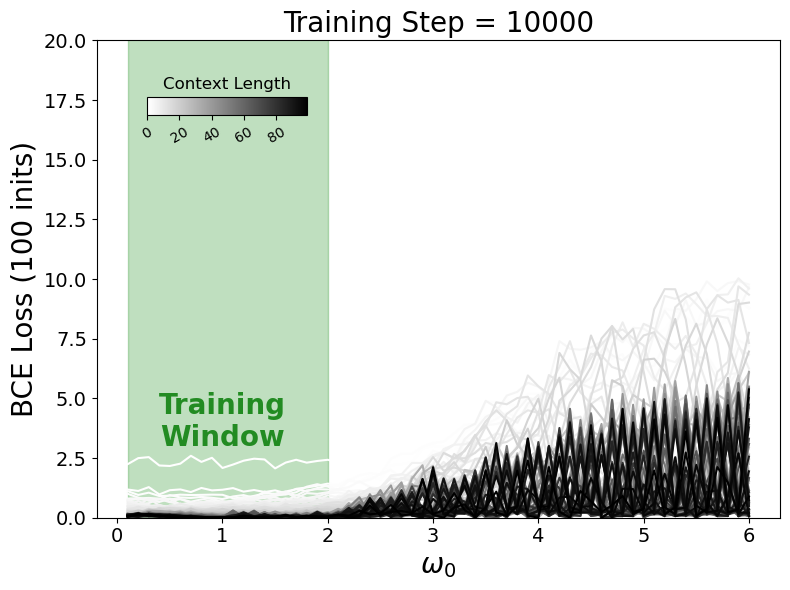

In [12]:
fig = plt.figure(figsize=(8,6))
ax = plt.gca()
cmap = plt.get_cmap("Greys")
colors = [cmap(i/(seq_len-2)) for i in range(seq_len-1)]

train_step = 10000
lines = []
for i in range(seq_len-1):
    line, = plt.plot(w0s,losses[train_step][:,i],color=colors[i],zorder=1)
    lines.append(line)
    
plt.title(f"Training Step = {train_step}",fontsize=20)
plt.fill_betweenx([0,25],[0.1,0.1],[2,2],color='green',alpha=0.25,zorder=0)
#plt.yscale('log')
plt.ylim([0,20])
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel(r"$\omega_0$",fontsize=20)
plt.ylabel(f"BCE Loss ({num_per} inits)",fontsize=20)
plt.text(1,3,"Training\nWindow",horizontalalignment='center',fontsize=20,fontweight='bold',color='forestgreen')

# Add a custom colorbar on top
cbar_ax = fig.add_axes([0.19, 0.8, 0.2, 0.03])  # [left, bottom, width, height]
norm = Normalize(vmin=1, vmax=seq_len-1)
cbar = ColorbarBase(cbar_ax, cmap='binary', norm=norm, orientation='horizontal')
# Customize the colorbar
cbar_ax.set_title("Context Length", fontsize=12)  # Title for the colorbar
ticks = np.arange(seq_len)[::20]
cbar_ax.set_xticks(ticks=ticks)
cbar_ax.tick_params(labelsize=10,rotation=30)

plt.tight_layout()
plt.savefig(f"{plot_dir}/loss_byW0_ctxOverlay_step{train_step}.png")
plt.savefig(f"{plot_dir}/loss_byW0_ctxOverlay_step{train_step}.pdf")
plt.show()

def update(frame):
    for i in range(seq_len-1):
        lines[i].set_ydata(losses[iter_ckpts[frame]][:,i])
    ax.set_title(f"Training Step = {iter_ckpts[frame]}",fontsize=20)
    return lines

# Create the animation
ani = FuncAnimation(fig, update, frames=len(iter_ckpts), interval=50, blit=True)

# Save the animation as a GIF
output_filename = f"{plot_dir}/loss_byW0_ctxOverlay_stepAnimation.gif"
ani.save(output_filename, writer=PillowWriter(fps=2))

# Close the figure after saving
plt.close(fig)

/var/folders/l6/xpd37x8x5md3j2v6qz37ptrc0000gn/T/ipykernel_43240/1043735519.py:35: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


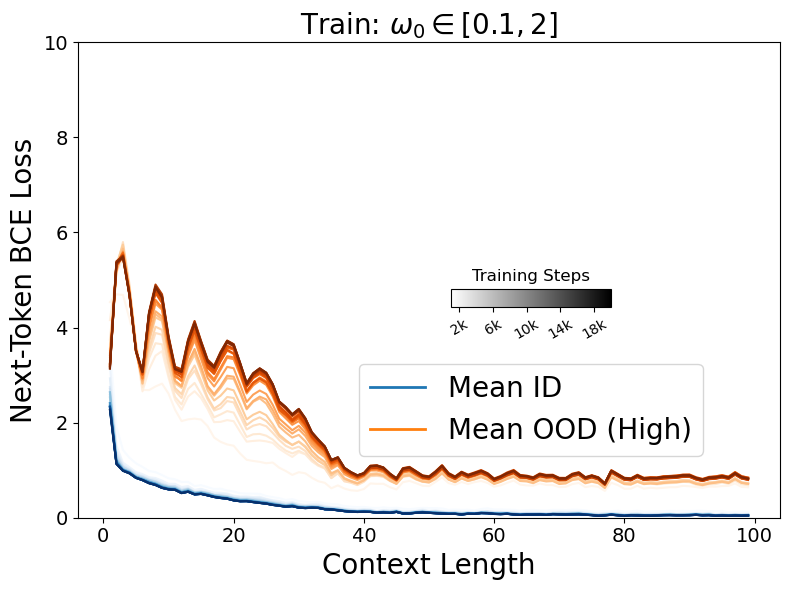

In [13]:
cmap_blues = plt.get_cmap('Blues')
cmap_oranges = plt.get_cmap("Oranges")
colors_blues = [cmap_blues(i / (len(iter_ckpts) - 1)) for i in range(len(iter_ckpts))]
colors_oranges = [cmap_oranges(i / (len(iter_ckpts) - 1)) for i in range(len(iter_ckpts))]
colors_greens = [plt.get_cmap("Greens")(i / (len(iter_ckpts) - 1)) for i in range(len(iter_ckpts))]

fig = plt.figure(figsize=(8,6))

for i,ni in enumerate(iter_ckpts):
    d_id = losses[ni][mask_id].mean(axis=0)
    d_ood = losses[ni][mask_ood].mean(axis=0)
    n_ctx = np.arange(1,losses[ni].shape[1]+1)
    plt.plot(n_ctx,d_id,color=colors_blues[i])
    plt.plot(n_ctx,d_ood,color=colors_oranges[i])
#plt.yscale('log')
plt.ylim([0,10])
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Context Length",fontsize=20)
plt.ylabel("Next-Token BCE Loss",fontsize=20)
plt.title(r"Train: $\omega_0 \in [0.1,2]$",fontsize=20)
l1 = Line2D([],[],label="Mean ID",lw=2,color="C0")
l2 = Line2D([],[],label="Mean OOD (High)",lw=2,color="C1")
plt.legend(handles=[l1,l2],loc=(0.4,0.13),fontsize=20)

# Add a custom colorbar on top
cbar_ax = fig.add_axes([0.57, 0.48, 0.2, 0.03])  # [left, bottom, width, height]
norm = Normalize(vmin=iter_ckpts[0], vmax=iter_ckpts[-1])
cbar = ColorbarBase(cbar_ax, cmap='binary', norm=norm, orientation='horizontal')
# Customize the colorbar
cbar_ax.set_title("Training Steps", fontsize=12)  # Title for the colorbar
cbar_ax.set_xticks(ticks=iter_ckpts[1::4],labels=[f"{k}" if k < 1000 else f"{k//1000}k" for k in iter_ckpts[1::4]])
cbar_ax.tick_params(labelsize=10,rotation=30)

plt.tight_layout()
plt.savefig(f"{plot_dir}/meanLoss_IID_OOD_byCtxLength_stepOverlay.png")
plt.savefig(f"{plot_dir}/meanLoss_IID_OOD_byCtxLength_stepOverlay.pdf")

/var/folders/l6/xpd37x8x5md3j2v6qz37ptrc0000gn/T/ipykernel_43240/1433148157.py:39: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


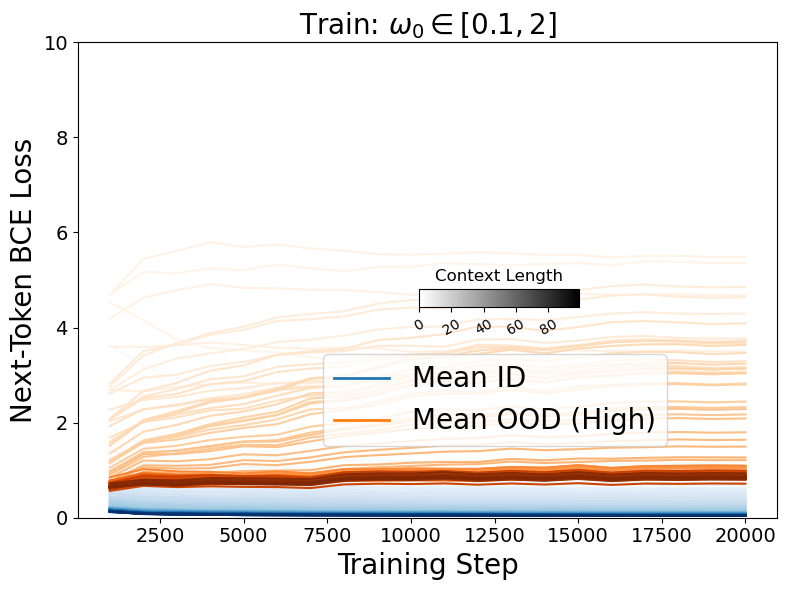

In [14]:
cmap_blues = plt.get_cmap('Blues')
cmap_oranges = plt.get_cmap("Oranges")
colors_blues = [cmap_blues(i / (seq_len - 2)) for i in range(seq_len-1)]
colors_oranges = [cmap_oranges(i / (seq_len - 2)) for i in range(seq_len-1)]
colors_greens = [plt.get_cmap("Greens")(i / (seq_len - 2)) for i in range(seq_len-1)]

fig = plt.figure(figsize=(8,6))

for nc in range(seq_len-1):
    l_id = []
    l_ood = []
    for nsteps in iter_ckpts:
        l_id.append(losses[nsteps][mask_id].mean(axis=0)[nc])
        l_ood.append(losses[nsteps][mask_ood].mean(axis=0)[nc])
    plt.plot(iter_ckpts,l_id,color=colors_blues[nc])
    plt.plot(iter_ckpts,l_ood,color=colors_oranges[nc])

#plt.yscale('log')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.ylim([0,10])
plt.xlabel("Training Step",fontsize=20)
plt.ylabel("Next-Token BCE Loss",fontsize=20)
plt.title(r"Train: $\omega_0 \in [0.1,2]$",fontsize=20)
l1 = Line2D([],[],label="Mean ID",lw=2,color="C0")
l2 = Line2D([],[],label="Mean OOD (High)",lw=2,color="C1")
plt.legend(handles=[l1,l2],loc=(0.35,0.15),fontsize=20)

# Add a custom colorbar on top
cbar_ax = fig.add_axes([0.53, 0.48, 0.2, 0.03])  # [left, bottom, width, height]
norm = Normalize(vmin=1, vmax=seq_len-1)
cbar = ColorbarBase(cbar_ax, cmap='binary', norm=norm, orientation='horizontal')
# Customize the colorbar
cbar_ax.set_title("Context Length", fontsize=12)  # Title for the colorbar
ticks = np.arange(0,seq_len)[::20]
cbar_ax.set_xticks(ticks=ticks)
cbar_ax.tick_params(labelsize=10,rotation=30)

plt.tight_layout()
plt.savefig(f"{plot_dir}/meanLoss_IID_OOD_byStep_ctxOverlay.png")
plt.savefig(f"{plot_dir}/meanLoss_IID_OOD_byStep_ctxOverlay.pdf")

In [15]:
for wsel in w0s:
    for ckpt_sel in [1000,5000,10000,15000,20000]:
        iw = list(w0s).index(wsel)
        fig = plt.figure(figsize=(8,6))
        
        d = losses[ckpt_sel][iw]
        n_ctx = np.arange(1,d.shape[0]+1)
        plt.plot(n_ctx,d,lw=2)
        
        plt.ylim([0,1.2*d.max()])
        plt.xticks(fontsize=14)
        plt.yticks(fontsize=14)
        plt.xlabel("Context Length",fontsize=20)
        plt.ylabel("Next-Token BCE Loss",fontsize=20)
        plt.title(r"Train: $\omega_0 \in [0.1,2]$",fontsize=20)
        
        ymax = plt.gca().get_ylim()[1]
        plt.text(20,0.9*ymax,f"Train Step = {ckpt_sel}\n"+rf"$\omega_0 = {wsel:.1f}$",fontsize=20,
                 verticalalignment='center',horizontalalignment='center')


        def f_fit(x,b,a,phi):
            return b + a*np.cos(2*wsel*x+phi)

        popt, pcov = curve_fit(f_fit, (n_ctx[19:])*dt, d[19:])
        plt.plot(n_ctx[19:],f_fit(dt*n_ctx[19:],*popt),color='red',linestyle='--',lw=2)

        line = Line2D([],[],lw=2,color='red',linestyle='--',label=r'$B + A\cos(2\omega_0 t + \phi)$')
        plt.legend(handles=[line],loc='upper right',fontsize=20)
        
        plt.tight_layout()

        out_dir = f"{plot_dir}/losses_byCtx/w{wsel:.1f}/"
        os.makedirs(out_dir,exist_ok=True)
        plt.savefig(f"{out_dir}/loss_byCtxLength_w0{wsel:.1f}_step{ckpt_sel}.png")
        plt.savefig(f"{out_dir}/loss_byCtxLength_w0{wsel:.1f}_step{ckpt_sel}.pdf")
        plt.close()

In [16]:
wsel = w0s[0]
for ckpt_sel in iter_ckpts:
    iw = list(w0s).index(wsel)
    fig = plt.figure(figsize=(8,6))
    ax = plt.gca()
    
    d = losses[ckpt_sel][iw]
    n_ctx = np.arange(1,d.shape[0]+1)
    line, = plt.plot(n_ctx,d)

    plt.yscale('log')
    plt.ylim([losses[ckpt_sel].min(),2*losses[ckpt_sel].max()])
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.xlabel("Context Length",fontsize=20)
    plt.ylabel("Next-Token BCE Loss",fontsize=20)
    plt.title(r"Train: $\omega_0 \in [0.1,2]$",fontsize=20)
    
    ymax = plt.gca().get_ylim()[1]
    text = plt.text(50,0.6*ymax,f"Train Step = {ckpt_sel}\n"+rf"$\omega_0 = {wsel:.1f}$",fontsize=20,
             verticalalignment='center',horizontalalignment='center')
    
    plt.tight_layout()

    out_dir = f"{plot_dir}/losses_byCtx/animate_varyW0/"
    os.makedirs(out_dir,exist_ok=True)
    
    def update(frame):
        wsel = w0s[frame]
        d = losses[ckpt_sel][frame]
        line.set_ydata(d)
        #ax.set_ylim([0,d.max()])
        text.set_text(f"Train Step = {ckpt_sel}\n"+rf"$\omega_0 = {wsel:.1f}$")
        #text.set_position((50,0.9*d.max()))
        return [line]
    
    # Create the animation
    ani = FuncAnimation(fig, update, frames=len(w0s), interval=50, blit=True)
    
    # Save the animation as a GIF
    output_filename = f"{out_dir}/animatedW0_step{ckpt_sel}.gif"
    ani.save(output_filename, writer=PillowWriter(fps=10))
    
    # Close the figure after saving
    plt.close(fig)

# Extrapolate $\omega_0$ high to low

In [18]:
model = "tokenized_continuousW0Beta_wHi_betaAll"
best_model, iter_models, iter_ckpts, config, model_dir = ptools.load_all_models(model,base_dir=base_dir)
dt = config['dataset_params']['dt']
seq_len = config['dataset_params']['seq_len']
tokenizer = utils.RealNumberTokenizer(config['model_params']['vocab_size'], config['training_params']['range_limit_tok'])
plot_dir = f"plots/{model}"
os.makedirs(plot_dir,exist_ok=True)

w0s = np.arange(0.1,6.1,0.1)
beta = 1
mask_id = (w0s>=2.0)&(w0s<=4.0)
mask_ood_hi = (w0s>4.0)
mask_ood_lo = (w0s<2.0)

In [19]:
num_per = 100
inpt = []
target = []
for w0 in w0s:
    dset = DampedSHODatasetV2(beta=beta,w0=w0,dt=dt,seq_len=seq_len)
    i,t = dset.sample(num_per,tokenizer=tokenizer)
    inpt.append(i)
    target.append(t)
inpt = torch.cat(inpt,dim=0)
target = torch.cat(target,dim=0)

losses = {}
with torch.no_grad():
    for i_it in tqdm(iter_ckpts):
        iter_models[i_it] = iter_models[i_it].to(device)
        pred = iter_models[i_it](inpt.to(device)).to('cpu')
        losses[i_it]= F.cross_entropy(pred.reshape(-1,pred.size(-1)),target.reshape(-1),reduction='none').view(-1,target.size(-1)).numpy()
        iter_models[i_it] = iter_models[i_it].to('cpu')

for i_it in iter_ckpts:
    losses[i_it] = losses[i_it].reshape(-1,num_per,seq_len-1).mean(axis=1)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:24<00:00,  1.21s/it]


/var/folders/l6/xpd37x8x5md3j2v6qz37ptrc0000gn/T/ipykernel_43240/2110985923.py:31: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


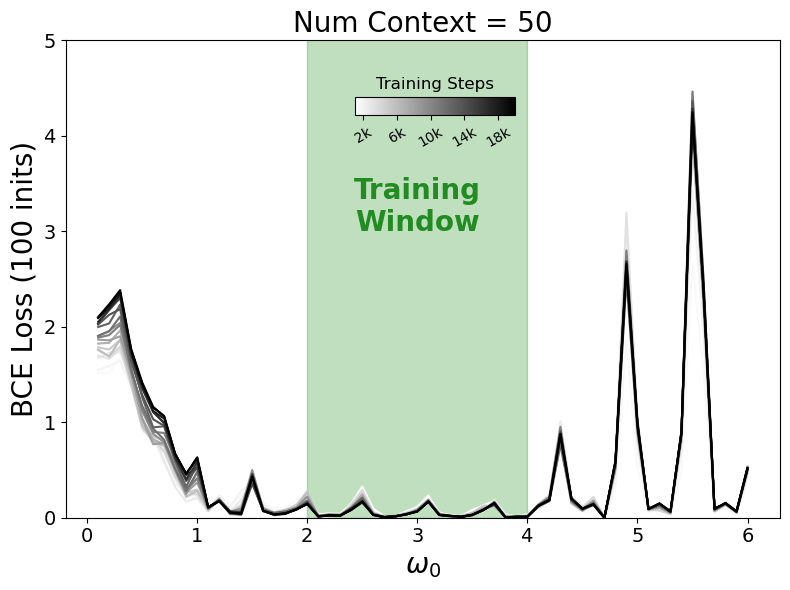

In [21]:
fig = plt.figure(figsize=(8,6))
ax = plt.gca()
cmap = plt.get_cmap("Greys")
colors = [cmap(i/(len(iter_ckpts)-1)) for i in range(len(iter_ckpts))]

n_ctx = 50
lines = []
for i,ck in enumerate(iter_ckpts):
    line, = plt.plot(w0s,losses[ck][:,n_ctx-1],color=colors[i],zorder=1)
    lines.append(line)
    
plt.title(f"Num Context = {n_ctx}",fontsize=20)
plt.fill_betweenx([0,25],[2,2],[4,4],color='green',alpha=0.25,zorder=0)
#plt.yscale('log')
plt.ylim([0,5])
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel(r"$\omega_0$",fontsize=20)
plt.ylabel(f"BCE Loss ({num_per} inits)",fontsize=20)
plt.text(3,3,"Training\nWindow",horizontalalignment='center',fontsize=20,fontweight='bold',color='forestgreen')

# Add a custom colorbar on top
cbar_ax = fig.add_axes([0.45, 0.8, 0.2, 0.03])  # [left, bottom, width, height]
norm = Normalize(vmin=iter_ckpts[0], vmax=iter_ckpts[-1])
cbar = ColorbarBase(cbar_ax, cmap='binary', norm=norm, orientation='horizontal')
# Customize the colorbar
cbar_ax.set_title("Training Steps", fontsize=12)  # Title for the colorbar
cbar_ax.set_xticks(ticks=iter_ckpts[1::4],labels=[f"{k}" if k < 1000 else f"{k//1000}k" for k in iter_ckpts[1::4]])
cbar_ax.tick_params(labelsize=10,rotation=30)

plt.tight_layout()
plt.savefig(f"{plot_dir}/loss_byW0_stepsOverlay_ctx{n_ctx}.png")
plt.savefig(f"{plot_dir}/loss_byW0_stepsOverlay_ctx{n_ctx}.pdf")
plt.show()

def update(frame):
    for i,ck in enumerate(iter_ckpts):
        lines[i].set_ydata(losses[ck][:,frame])
    ax.set_title(f"Num Context = {frame+1}",fontsize=20)
    return lines

# Create the animation
ani = FuncAnimation(fig, update, frames=losses[20000].shape[1], interval=50, blit=True)

# Save the animation as a GIF
output_filename = f"{plot_dir}/loss_byW0_stepsOverlay_ctxAnimation.gif"
ani.save(output_filename, writer=PillowWriter(fps=20))

# Close the figure after saving
plt.close(fig)

/var/folders/l6/xpd37x8x5md3j2v6qz37ptrc0000gn/T/ipykernel_34394/149006197.py:32: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


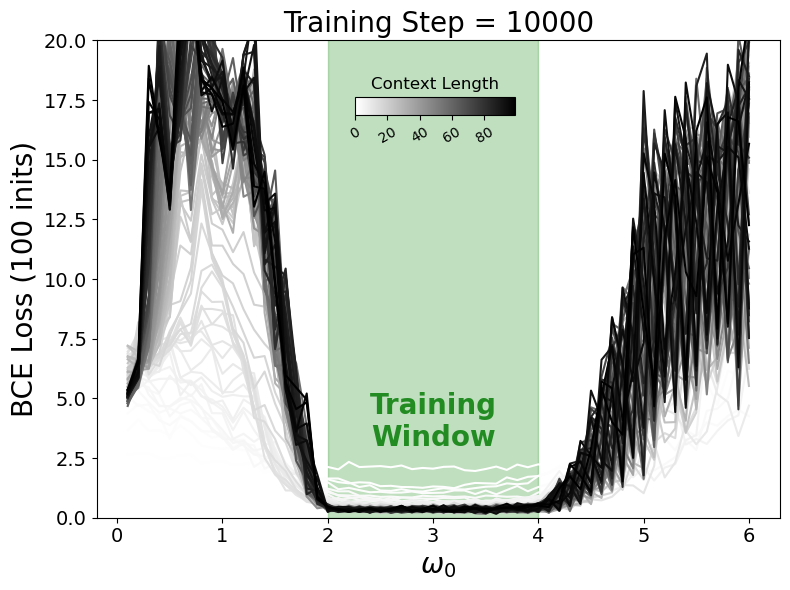

In [142]:
fig = plt.figure(figsize=(8,6))
ax = plt.gca()
cmap = plt.get_cmap("Greys")
colors = [cmap(i/(seq_len-2)) for i in range(seq_len-1)]

train_step = 10000
lines = []
for i in range(seq_len-1):
    line, = plt.plot(w0s,losses[train_step][:,i],color=colors[i],zorder=1)
    lines.append(line)
    
plt.title(f"Training Step = {train_step}",fontsize=20)
plt.fill_betweenx([0,25],[2,2],[4,4],color='green',alpha=0.25,zorder=0)
#plt.yscale('log')
plt.ylim([0,20])
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel(r"$\omega_0$",fontsize=20)
plt.ylabel(f"BCE Loss ({num_per} inits)",fontsize=20)
plt.text(3,3,"Training\nWindow",horizontalalignment='center',fontsize=20,fontweight='bold',color='forestgreen')

# Add a custom colorbar on top
cbar_ax = fig.add_axes([0.45, 0.8, 0.2, 0.03])  # [left, bottom, width, height]
norm = Normalize(vmin=1, vmax=seq_len-1)
cbar = ColorbarBase(cbar_ax, cmap='binary', norm=norm, orientation='horizontal')
# Customize the colorbar
cbar_ax.set_title("Context Length", fontsize=12)  # Title for the colorbar
ticks = np.arange(seq_len)[::20]
cbar_ax.set_xticks(ticks=ticks)
cbar_ax.tick_params(labelsize=10,rotation=30)

plt.tight_layout()
plt.savefig(f"{plot_dir}/loss_byW0_ctxOverlay_step{train_step}.png")
plt.savefig(f"{plot_dir}/loss_byW0_ctxOverlay_step{train_step}.pdf")
plt.show()

def update(frame):
    for i in range(seq_len-1):
        lines[i].set_ydata(losses[iter_ckpts[frame]][:,i])
    ax.set_title(f"Training Step = {iter_ckpts[frame]}",fontsize=20)
    return lines

# Create the animation
ani = FuncAnimation(fig, update, frames=len(iter_ckpts), interval=50, blit=True)

# Save the animation as a GIF
output_filename = f"{plot_dir}/loss_byW0_ctxOverlay_stepAnimation.gif"
ani.save(output_filename, writer=PillowWriter(fps=2))

# Close the figure after saving
plt.close(fig)

/var/folders/l6/xpd37x8x5md3j2v6qz37ptrc0000gn/T/ipykernel_34394/4087557894.py:38: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


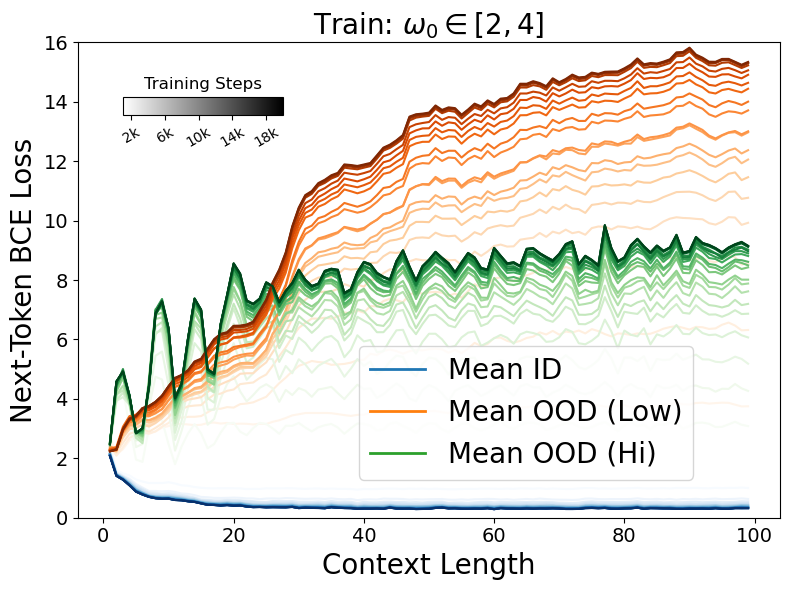

In [159]:
cmap_blues = plt.get_cmap('Blues')
cmap_oranges = plt.get_cmap("Oranges")
colors_blues = [cmap_blues(i / (len(iter_ckpts) - 1)) for i in range(len(iter_ckpts))]
colors_oranges = [cmap_oranges(i / (len(iter_ckpts) - 1)) for i in range(len(iter_ckpts))]
colors_greens = [plt.get_cmap("Greens")(i / (len(iter_ckpts) - 1)) for i in range(len(iter_ckpts))]

fig = plt.figure(figsize=(8,6))

for i,ni in enumerate(iter_ckpts):
    d_id = losses[ni][mask_id].mean(axis=0)
    d_ood_lo = losses[ni][mask_ood_lo].mean(axis=0)
    d_ood_hi = losses[ni][mask_ood_hi].mean(axis=0)
    n_ctx = np.arange(1,losses[ni].shape[1]+1)
    plt.plot(n_ctx,d_id,color=colors_blues[i])
    plt.plot(n_ctx,d_ood_lo,color=colors_oranges[i])
    plt.plot(n_ctx,d_ood_hi,color=colors_greens[i])
#plt.yscale('log')
plt.ylim([0,16])
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Context Length",fontsize=20)
plt.ylabel("Next-Token BCE Loss",fontsize=20)
plt.title(r"Train: $\omega_0 \in [2,4]$",fontsize=20)
l1 = Line2D([],[],label="Mean ID",lw=2,color="C0")
l2 = Line2D([],[],label="Mean OOD (Low)",lw=2,color="C1")
l3 = Line2D([],[],label="Mean OOD (Hi)",lw=2,color="C2")
plt.legend(handles=[l1,l2,l3],loc=(0.4,0.08),fontsize=20)

# Add a custom colorbar on top
cbar_ax = fig.add_axes([0.16, 0.8, 0.2, 0.03])  # [left, bottom, width, height]
norm = Normalize(vmin=iter_ckpts[0], vmax=iter_ckpts[-1])
cbar = ColorbarBase(cbar_ax, cmap='binary', norm=norm, orientation='horizontal')
# Customize the colorbar
cbar_ax.set_title("Training Steps", fontsize=12)  # Title for the colorbar
cbar_ax.set_xticks(ticks=iter_ckpts[1::4],labels=[f"{k}" if k < 1000 else f"{k//1000}k" for k in iter_ckpts[1::4]])
cbar_ax.tick_params(labelsize=10,rotation=30)

plt.tight_layout()
plt.savefig(f"{plot_dir}/meanLoss_IID_OOD_byCtxLength_stepOverlay.png")
plt.savefig(f"{plot_dir}/meanLoss_IID_OOD_byCtxLength_stepOverlay.pdf")

/var/folders/l6/xpd37x8x5md3j2v6qz37ptrc0000gn/T/ipykernel_34394/3303480676.py:43: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


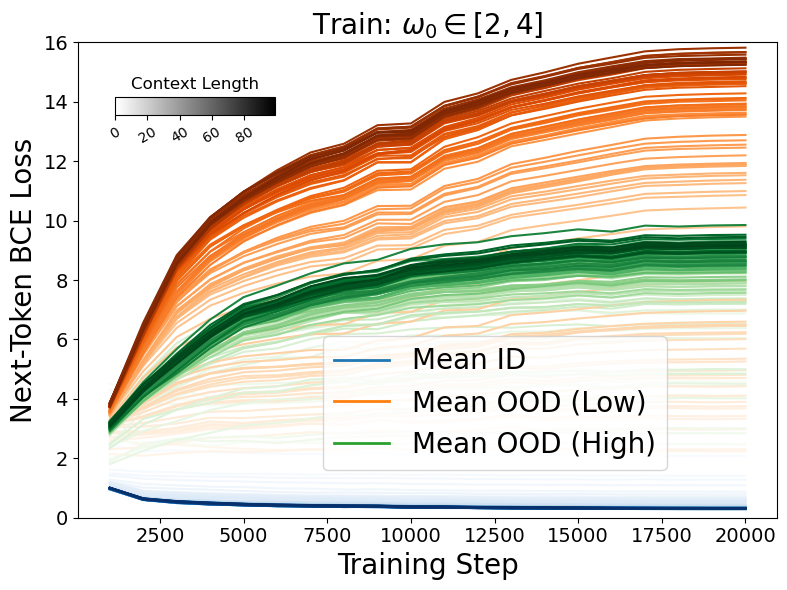

In [160]:
cmap_blues = plt.get_cmap('Blues')
cmap_oranges = plt.get_cmap("Oranges")
colors_blues = [cmap_blues(i / (seq_len - 2)) for i in range(seq_len-1)]
colors_oranges = [cmap_oranges(i / (seq_len - 2)) for i in range(seq_len-1)]
colors_greens = [plt.get_cmap("Greens")(i / (seq_len - 2)) for i in range(seq_len-1)]

fig = plt.figure(figsize=(8,6))

for nc in range(seq_len-1):
    l_id = []
    l_ood_lo = []
    l_ood_hi = []
    for nsteps in iter_ckpts:
        l_id.append(losses[nsteps][mask_id].mean(axis=0)[nc])
        l_ood_lo.append(losses[nsteps][mask_ood_lo].mean(axis=0)[nc])
        l_ood_hi.append(losses[nsteps][mask_ood_hi].mean(axis=0)[nc])
    plt.plot(iter_ckpts,l_id,color=colors_blues[nc])
    plt.plot(iter_ckpts,l_ood_lo,color=colors_oranges[nc])
    plt.plot(iter_ckpts,l_ood_hi,color=colors_greens[nc])

#plt.yscale('log')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.ylim([0,16])
plt.xlabel("Training Step",fontsize=20)
plt.ylabel("Next-Token BCE Loss",fontsize=20)
plt.title(r"Train: $\omega_0 \in [2,4]$",fontsize=20)
l1 = Line2D([],[],label="Mean ID",lw=2,color="C0")
l2 = Line2D([],[],label="Mean OOD (Low)",lw=2,color="C1")
l3 = Line2D([],[],label="Mean OOD (High)",lw=2,color="C2")
plt.legend(handles=[l1,l2,l3],loc=(0.35,0.1),fontsize=20)

# Add a custom colorbar on top
cbar_ax = fig.add_axes([0.15, 0.8, 0.2, 0.03])  # [left, bottom, width, height]
norm = Normalize(vmin=1, vmax=seq_len-1)
cbar = ColorbarBase(cbar_ax, cmap='binary', norm=norm, orientation='horizontal')
# Customize the colorbar
cbar_ax.set_title("Context Length", fontsize=12)  # Title for the colorbar
ticks = np.arange(0,seq_len)[::20]
cbar_ax.set_xticks(ticks=ticks)
cbar_ax.tick_params(labelsize=10,rotation=30)

plt.tight_layout()
plt.savefig(f"{plot_dir}/meanLoss_IID_OOD_byStep_ctxOverlay.png")
plt.savefig(f"{plot_dir}/meanLoss_IID_OOD_byStep_ctxOverlay.pdf")

In [164]:
for wsel in w0s:
    for ckpt_sel in [1000,5000,10000,15000,20000]:
        iw = list(w0s).index(wsel)
        fig = plt.figure(figsize=(8,6))
        
        d = losses[ckpt_sel][iw]
        n_ctx = np.arange(1,d.shape[0]+1)
        plt.plot(n_ctx,d,lw=2)
        
        plt.ylim([0,1.2*d.max()])
        plt.xticks(fontsize=14)
        plt.yticks(fontsize=14)
        plt.xlabel("Context Length",fontsize=20)
        plt.ylabel("Next-Token BCE Loss",fontsize=20)
        plt.title(r"Train: $\omega_0 \in [2,4]$",fontsize=20)
        
        ymax = plt.gca().get_ylim()[1]
        plt.text(20,0.9*ymax,f"Train Step = {ckpt_sel}\n"+rf"$\omega_0 = {wsel:.1f}$",fontsize=20,
                 verticalalignment='center',horizontalalignment='center')


        def f_fit(x,b,a,phi):
            return b + a*np.cos(2*wsel*x+phi)

        popt, pcov = curve_fit(f_fit, (n_ctx[19:])*dt, d[19:])
        plt.plot(n_ctx[19:],f_fit(dt*n_ctx[19:],*popt),color='red',linestyle='--',lw=2)

        line = Line2D([],[],lw=2,color='red',linestyle='--',label=r'$B + A\cos(2\omega_0 t + \phi)$')
        plt.legend(handles=[line],loc='upper right',fontsize=20)
        
        plt.tight_layout()

        out_dir = f"{plot_dir}/losses_byCtx/w{wsel:.1f}/"
        os.makedirs(out_dir,exist_ok=True)
        plt.savefig(f"{out_dir}/loss_byCtxLength_w0{wsel:.1f}_step{ckpt_sel}.png")
        plt.savefig(f"{out_dir}/loss_byCtxLength_w0{wsel:.1f}_step{ckpt_sel}.pdf")
        plt.close()

In [166]:
wsel = w0s[0]
for ckpt_sel in iter_ckpts:
    iw = list(w0s).index(wsel)
    fig = plt.figure(figsize=(8,6))
    ax = plt.gca()
    
    d = losses[ckpt_sel][iw]
    n_ctx = np.arange(1,d.shape[0]+1)
    line, = plt.plot(n_ctx,d)

    plt.yscale('log')
    plt.ylim([losses[ckpt_sel].min(),2*losses[ckpt_sel].max()])
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.xlabel("Context Length",fontsize=20)
    plt.ylabel("Next-Token BCE Loss",fontsize=20)
    plt.title(r"Train: $\omega_0 \in [2,4]$",fontsize=20)
    
    ymax = plt.gca().get_ylim()[1]
    text = plt.text(50,0.6*ymax,f"Train Step = {ckpt_sel}\n"+rf"$\omega_0 = {wsel:.1f}$",fontsize=20,
             verticalalignment='center',horizontalalignment='center')
    
    plt.tight_layout()

    out_dir = f"{plot_dir}/losses_byCtx/animate_varyW0/"
    os.makedirs(out_dir,exist_ok=True)
    
    def update(frame):
        wsel = w0s[frame]
        d = losses[ckpt_sel][frame]
        line.set_ydata(d)
        #ax.set_ylim([0,d.max()])
        text.set_text(f"Train Step = {ckpt_sel}\n"+rf"$\omega_0 = {wsel:.1f}$")
        #text.set_position((50,0.9*d.max()))
        return [line]
    
    # Create the animation
    ani = FuncAnimation(fig, update, frames=len(w0s), interval=50, blit=True)
    
    # Save the animation as a GIF
    output_filename = f"{out_dir}/animatedW0_step{ckpt_sel}.gif"
    ani.save(output_filename, writer=PillowWriter(fps=10))
    
    # Close the figure after saving
    plt.close(fig)

# Interpolate $\omega_0$

In [8]:
model = "tokenized_continuousW0Beta_wLoHi_beta0"
best_model, iter_models, iter_ckpts, config, model_dir = ptools.load_all_models(model,base_dir=base_dir)
dt = config['dataset_params']['dt']
seq_len = config['dataset_params']['seq_len']
tokenizer = utils.RealNumberTokenizer(config['model_params']['vocab_size'], config['training_params']['range_limit_tok'])
plot_dir = f"plots/{model}"
os.makedirs(plot_dir,exist_ok=True)

w0s = np.arange(0.1,6.1,0.1)
mask_id = ((w0s>=0.1)&(w0s<=2.0)) | ((w0s>=3.0)&(w0s<4.0))
mask_interp = (w0s>2.0)&(w0s<3.0)
mask_ood = w0s>4.0

In [9]:
num_per = 100
inpt = []
target = []
for w0 in w0s:
    dset = DampedSHODatasetV2(beta=0,w0=w0,dt=dt,seq_len=seq_len)
    i,t = dset.sample(num_per,tokenizer=tokenizer)
    inpt.append(i)
    target.append(t)
inpt = torch.cat(inpt,dim=0)
target = torch.cat(target,dim=0)

losses = {}
with torch.no_grad():
    for i_it in tqdm(iter_ckpts):
        iter_models[i_it] = iter_models[i_it].to(device)
        pred = iter_models[i_it](inpt.to(device)).to('cpu')
        losses[i_it]= F.cross_entropy(pred.reshape(-1,pred.size(-1)),target.reshape(-1),reduction='none').view(-1,target.size(-1)).numpy()
        iter_models[i_it] = iter_models[i_it].to('cpu')

for i_it in iter_ckpts:
    losses[i_it] = losses[i_it].reshape(-1,num_per,seq_len-1).mean(axis=1)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:12<00:00,  1.58it/s]


/var/folders/l6/xpd37x8x5md3j2v6qz37ptrc0000gn/T/ipykernel_34394/3595010709.py:34: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


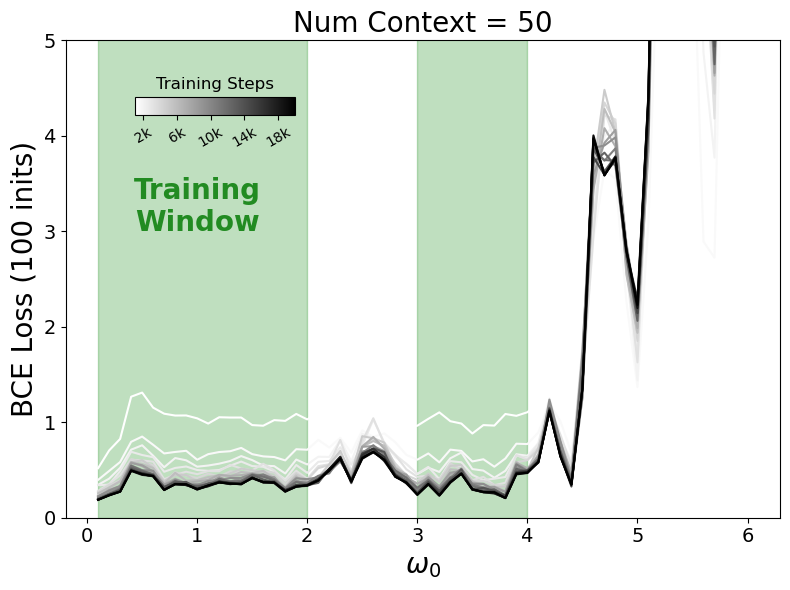

<Figure size 640x480 with 0 Axes>

In [10]:
fig = plt.figure(figsize=(8,6))
ax = plt.gca()
cmap = plt.get_cmap("Greys")
colors = [cmap(i/(len(iter_ckpts)-1)) for i in range(len(iter_ckpts))]

n_ctx = 50
lines = []
for i,ck in enumerate(iter_ckpts):
    line, = plt.plot(w0s,losses[ck][:,n_ctx-1],color=colors[i],zorder=1)
    lines.append(line)
    
plt.title(f"Num Context = {n_ctx}",fontsize=20)
plt.fill_betweenx([0,25],[0.1,0.1],[2,2],color='green',alpha=0.25,zorder=0)
plt.fill_betweenx([0,25],[3,3],[4,4],color='green',alpha=0.25,zorder=0)
#plt.yscale('log')
plt.ylim([0,5])
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel(r"$\omega_0$",fontsize=20)
plt.ylabel(f"BCE Loss ({num_per} inits)",fontsize=20)
#p = Patch(color='green',alpha=0.25,label="Training \nWindow")
#plt.legend(handles=[p],loc='upper right',fontsize=18)
plt.text(1,3,"Training\nWindow",horizontalalignment='center',fontsize=20,fontweight='bold',color='forestgreen')

# Add a custom colorbar on top
cbar_ax = fig.add_axes([0.175, 0.8, 0.2, 0.03])  # [left, bottom, width, height]
norm = Normalize(vmin=iter_ckpts[0], vmax=iter_ckpts[-1])
cbar = ColorbarBase(cbar_ax, cmap='binary', norm=norm, orientation='horizontal')
# Customize the colorbar
cbar_ax.set_title("Training Steps", fontsize=12)  # Title for the colorbar
cbar_ax.set_xticks(ticks=iter_ckpts[1::4],labels=[f"{k}" if k < 1000 else f"{k//1000}k" for k in iter_ckpts[1::4]])
cbar_ax.tick_params(labelsize=10,rotation=30)

plt.tight_layout()
plt.show()
plt.savefig(f"{plot_dir}/loss_byW0_stepsOverlay_ctx{n_ctx}.png")
plt.savefig(f"{plot_dir}/loss_byW0_stepsOverlay_ctx{n_ctx}.pdf")

def update(frame):
    for i,ck in enumerate(iter_ckpts):
        lines[i].set_ydata(losses[ck][:,frame])
    ax.set_title(f"Num Context = {frame+1}",fontsize=20)
    return lines

# Create the animation
ani = FuncAnimation(fig, update, frames=losses[20000].shape[1], interval=50, blit=True)

# Save the animation as a GIF
output_filename = f"{plot_dir}/loss_byW0_stepsOverlay_ctxAnimation.gif"
ani.save(output_filename, writer=PillowWriter(fps=20))

# Close the figure after saving
plt.close(fig)

/var/folders/l6/xpd37x8x5md3j2v6qz37ptrc0000gn/T/ipykernel_34394/3953321514.py:35: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


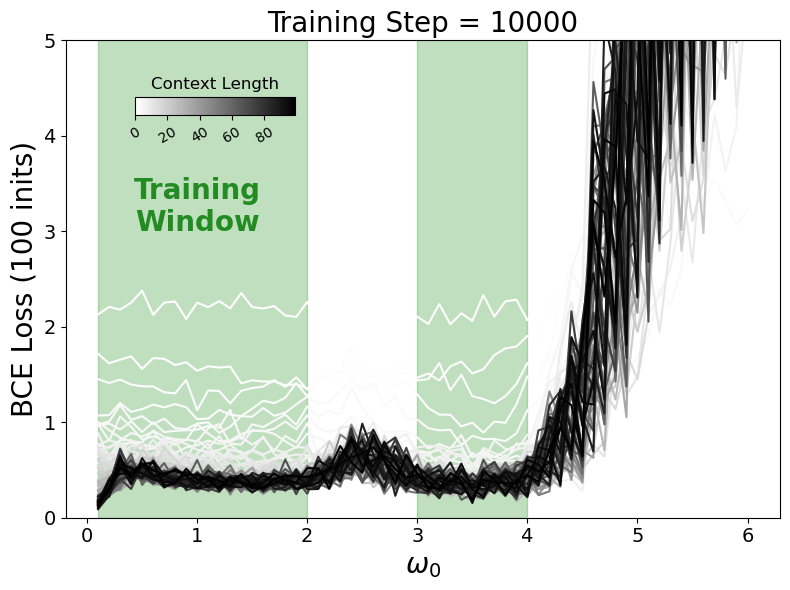

<Figure size 640x480 with 0 Axes>

In [11]:
fig = plt.figure(figsize=(8,6))
ax = plt.gca()
cmap = plt.get_cmap("Greys")
colors = [cmap(i/(seq_len-2)) for i in range(seq_len-1)]

train_step = 10000
lines = []
for i in range(seq_len-1):
    line, = plt.plot(w0s,losses[train_step][:,i],color=colors[i],zorder=1)
    lines.append(line)
    
plt.title(f"Training Step = {train_step}",fontsize=20)
plt.fill_betweenx([0,25],[0.1,0.1],[2,2],color='green',alpha=0.25,zorder=0)
plt.fill_betweenx([0,25],[3,3],[4,4],color='green',alpha=0.25,zorder=0)
#plt.yscale('log')
plt.ylim([0,5])
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel(r"$\omega_0$",fontsize=20)
plt.ylabel(f"BCE Loss ({num_per} inits)",fontsize=20)
#p = Patch(color='green',alpha=0.25,label="Training \nWindow")
#plt.legend(handles=[p],loc='upper right',fontsize=18)
plt.text(1,3,"Training\nWindow",horizontalalignment='center',fontsize=20,fontweight='bold',color='forestgreen')

# Add a custom colorbar on top
cbar_ax = fig.add_axes([0.175, 0.8, 0.2, 0.03])  # [left, bottom, width, height]
norm = Normalize(vmin=1, vmax=seq_len-1)
cbar = ColorbarBase(cbar_ax, cmap='binary', norm=norm, orientation='horizontal')
# Customize the colorbar
cbar_ax.set_title("Context Length", fontsize=12)  # Title for the colorbar
ticks = np.arange(seq_len)[::20]
cbar_ax.set_xticks(ticks=ticks)
cbar_ax.tick_params(labelsize=10,rotation=30)

plt.tight_layout()
plt.show()
plt.savefig(f"{plot_dir}/loss_byW0_ctxOverlay_step{train_step}.png")
plt.savefig(f"{plot_dir}/loss_byW0_ctxOverlay_step{train_step}.pdf")

def update(frame):
    for i in range(seq_len-1):
        lines[i].set_ydata(losses[iter_ckpts[frame]][:,i])
    ax.set_title(f"Training Step = {iter_ckpts[frame]}",fontsize=20)
    return lines

# Create the animation
ani = FuncAnimation(fig, update, frames=len(iter_ckpts), interval=50, blit=True)

# Save the animation as a GIF
output_filename = f"{plot_dir}/loss_byW0_ctxOverlay_stepAnimation.gif"
ani.save(output_filename, writer=PillowWriter(fps=2))

# Close the figure after saving
plt.close(fig)

/var/folders/l6/xpd37x8x5md3j2v6qz37ptrc0000gn/T/ipykernel_34394/1039590240.py:38: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


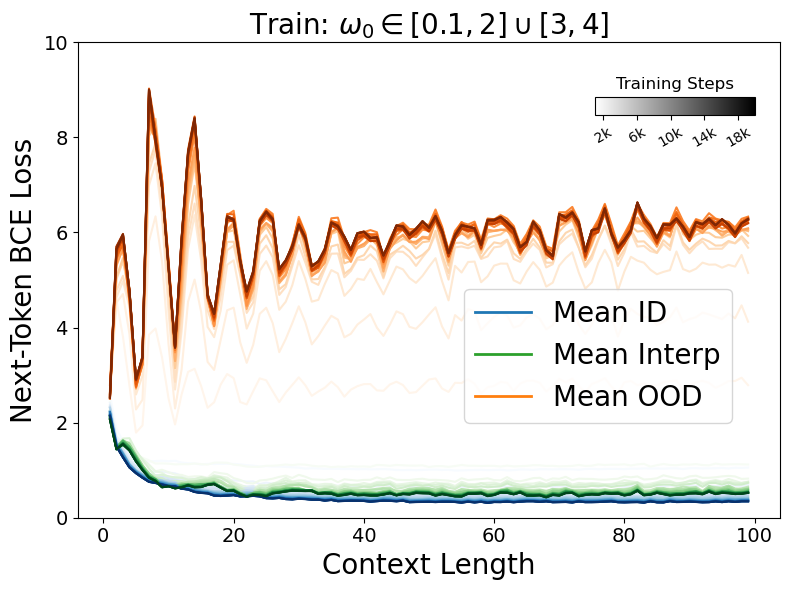

In [22]:
cmap_blues = plt.get_cmap('Blues')
cmap_oranges = plt.get_cmap("Oranges")
colors_blues = [cmap_blues(i / (len(iter_ckpts) - 1)) for i in range(len(iter_ckpts))]
colors_oranges = [cmap_oranges(i / (len(iter_ckpts) - 1)) for i in range(len(iter_ckpts))]
colors_greens = [plt.get_cmap("Greens")(i / (len(iter_ckpts) - 1)) for i in range(len(iter_ckpts))]

fig = plt.figure(figsize=(8,6))

for i,ni in enumerate(iter_ckpts):
    d_id = losses[ni][mask_id].mean(axis=0)
    d_interp = losses[ni][mask_interp].mean(axis=0)
    d_ood = losses[ni][mask_ood].mean(axis=0)
    n_ctx = np.arange(1,losses[ni].shape[1]+1)
    plt.plot(n_ctx,d_id,color=colors_blues[i])
    plt.plot(n_ctx,d_ood,color=colors_oranges[i])
    plt.plot(n_ctx,d_interp,color=colors_greens[i])
#plt.yscale('log')
plt.ylim([0,10])
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Context Length",fontsize=20)
plt.ylabel("Next-Token BCE Loss",fontsize=20)
plt.title(r"Train: $\omega_0 \in [0.1,2] \cup [3,4]$",fontsize=20)
l1 = Line2D([],[],label="Mean ID",lw=2,color="C0")
l2 = Line2D([],[],label="Mean OOD",lw=2,color="C1")
l3 = Line2D([],[],label="Mean Interp",lw=2,color="C2")
plt.legend(handles=[l1,l3,l2],loc=(0.55,0.2),fontsize=20)

# Add a custom colorbar on top
cbar_ax = fig.add_axes([0.75, 0.8, 0.2, 0.03])  # [left, bottom, width, height]
norm = Normalize(vmin=iter_ckpts[0], vmax=iter_ckpts[-1])
cbar = ColorbarBase(cbar_ax, cmap='binary', norm=norm, orientation='horizontal')
# Customize the colorbar
cbar_ax.set_title("Training Steps", fontsize=12)  # Title for the colorbar
cbar_ax.set_xticks(ticks=iter_ckpts[1::4],labels=[f"{k}" if k < 1000 else f"{k//1000}k" for k in iter_ckpts[1::4]])
cbar_ax.tick_params(labelsize=10,rotation=30)

plt.tight_layout()
plt.savefig(f"{plot_dir}/meanLoss_IID_OOD_byCtxLength_stepOverlay.png")
plt.savefig(f"{plot_dir}/meanLoss_IID_OOD_byCtxLength_stepOverlay.pdf")

/var/folders/l6/xpd37x8x5md3j2v6qz37ptrc0000gn/T/ipykernel_34394/2137237409.py:42: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


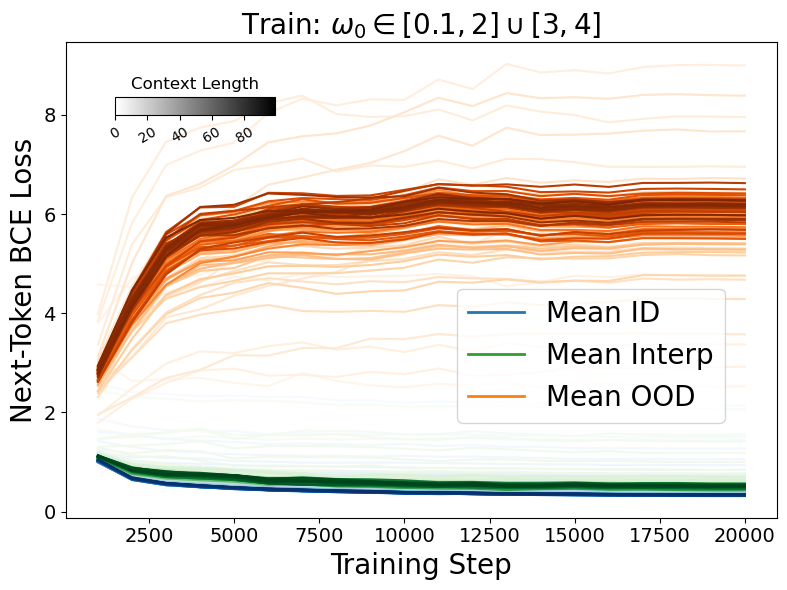

In [23]:
cmap_blues = plt.get_cmap('Blues')
cmap_oranges = plt.get_cmap("Oranges")
colors_blues = [cmap_blues(i / (seq_len - 2)) for i in range(seq_len-1)]
colors_oranges = [cmap_oranges(i / (seq_len - 2)) for i in range(seq_len-1)]
colors_greens = [plt.get_cmap("Greens")(i / (seq_len - 2)) for i in range(seq_len-1)]

fig = plt.figure(figsize=(8,6))

for nc in range(seq_len-1):
    l_id = []
    l_ood = []
    l_interp = []
    for nsteps in iter_ckpts:
        l_id.append(losses[nsteps][mask_id].mean(axis=0)[nc])
        l_ood.append(losses[nsteps][mask_ood].mean(axis=0)[nc])
        l_interp.append(losses[nsteps][mask_interp].mean(axis=0)[nc])
    plt.plot(iter_ckpts,l_id,color=colors_blues[nc])
    plt.plot(iter_ckpts,l_ood,color=colors_oranges[nc])
    plt.plot(iter_ckpts,l_interp,color=colors_greens[nc])

#plt.yscale('log')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Training Step",fontsize=20)
plt.ylabel("Next-Token BCE Loss",fontsize=20)
plt.title(r"Train: $\omega_0 \in [0.1,2] \cup [3,4]$",fontsize=20)
l1 = Line2D([],[],label="Mean ID",lw=2,color="C0")
l2 = Line2D([],[],label="Mean OOD",lw=2,color="C1")
l3 = Line2D([],[],label="Mean Interp",lw=2,color="C2")
plt.legend(handles=[l1,l3,l2],loc=(0.55,0.2),fontsize=20)

# Add a custom colorbar on top
cbar_ax = fig.add_axes([0.15, 0.8, 0.2, 0.03])  # [left, bottom, width, height]
norm = Normalize(vmin=1, vmax=seq_len-1)
cbar = ColorbarBase(cbar_ax, cmap='binary', norm=norm, orientation='horizontal')
# Customize the colorbar
cbar_ax.set_title("Context Length", fontsize=12)  # Title for the colorbar
ticks = np.arange(0,seq_len)[::20]
cbar_ax.set_xticks(ticks=ticks)
cbar_ax.tick_params(labelsize=10,rotation=30)

plt.tight_layout()
plt.savefig(f"{plot_dir}/meanLoss_IID_OOD_byStep_ctxOverlay.png")
plt.savefig(f"{plot_dir}/meanLoss_IID_OOD_byStep_ctxOverlay.pdf")

In [53]:
for wsel in w0s:
    for ckpt_sel in [1000,5000,10000,15000,20000]:
        iw = list(w0s).index(wsel)
        fig = plt.figure(figsize=(8,6))
        
        d = losses[ckpt_sel][iw]
        n_ctx = np.arange(1,d.shape[0]+1)
        plt.plot(n_ctx,d,lw=2)
        
        plt.ylim([0,1.2*d.max()])
        plt.xticks(fontsize=14)
        plt.yticks(fontsize=14)
        plt.xlabel("Context Length",fontsize=20)
        plt.ylabel("Next-Token BCE Loss",fontsize=20)
        plt.title(r"Train: $\omega_0 \in [0.1,2] \cup [3,4]$",fontsize=20)
        
        ymax = plt.gca().get_ylim()[1]
        plt.text(20,0.9*ymax,f"Train Step = {ckpt_sel}\n"+rf"$\omega_0 = {wsel:.1f}$",fontsize=20,
                 verticalalignment='center',horizontalalignment='center')

        def f_fit(x,b,a,phi):
            return b + a*np.cos(2*wsel*x+phi)

        popt, pcov = curve_fit(f_fit, (n_ctx[19:])*dt, d[19:])
        plt.plot(n_ctx[19:],f_fit(dt*n_ctx[19:],*popt),color='red',linestyle='--',lw=2)
        line = Line2D([],[],lw=2,color='red',linestyle='--',label=r'$B + A\cos(2\omega_0 t + \phi)$')
        plt.legend(handles=[line],loc='upper right',fontsize=20)
        
        plt.tight_layout()

        out_dir = f"{plot_dir}/losses_byCtx/w{wsel:.1f}/"
        os.makedirs(out_dir,exist_ok=True)
        plt.savefig(f"{out_dir}/loss_byCtxLength_w0{wsel:.1f}_step{ckpt_sel}.png")
        plt.savefig(f"{out_dir}/loss_byCtxLength_w0{wsel:.1f}_step{ckpt_sel}.pdf")
        plt.close()

In [57]:
wsel = w0s[0]
for ckpt_sel in iter_ckpts:
    iw = list(w0s).index(wsel)
    fig = plt.figure(figsize=(8,6))
    ax = plt.gca()
    
    d = losses[ckpt_sel][iw]
    n_ctx = np.arange(1,d.shape[0]+1)
    line, = plt.plot(n_ctx,d)

    plt.yscale('log')
    plt.ylim([None,2*losses[ckpt_sel].max()])
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.xlabel("Context Length",fontsize=20)
    plt.ylabel("Next-Token BCE Loss",fontsize=20)
    plt.title(r"Train: $\omega_0 \in [0.1,2] \cup [3,4]$",fontsize=20)
    
    ymax = plt.gca().get_ylim()[1]
    text = plt.text(50,0.6*ymax,f"Train Step = {ckpt_sel}\n"+rf"$\omega_0 = {wsel:.1f}$",fontsize=20,
             verticalalignment='center',horizontalalignment='center')
    
    plt.tight_layout()

    out_dir = f"{plot_dir}/losses_byCtx/animate_varyW0/"
    os.makedirs(out_dir,exist_ok=True)
    
    def update(frame):
        wsel = w0s[frame]
        d = losses[ckpt_sel][frame]
        line.set_ydata(d)
        #ax.set_ylim([0,d.max()])
        text.set_text(f"Train Step = {ckpt_sel}\n"+rf"$\omega_0 = {wsel:.1f}$")
        #text.set_position((50,0.9*d.max()))
        return [line]
    
    # Create the animation
    ani = FuncAnimation(fig, update, frames=len(w0s), interval=50, blit=True)
    
    # Save the animation as a GIF
    output_filename = f"{out_dir}/animatedW0_step{ckpt_sel}.gif"
    ani.save(output_filename, writer=PillowWriter(fps=10))
    
    # Close the figure after saving
    plt.close(fig)

In [110]:
# create dataset for forecasting
num_per = 100
n_forecast = 20
inpt = []
target = []
for w0 in w0s:
    dset = DampedSHODatasetV2(beta=0,w0=w0,dt=dt,seq_len=seq_len+n_forecast)
    i,t = dset.sample(num_per,tokenizer=tokenizer)
    inpt.append(i)
    target.append(t)
inpt = torch.cat(inpt,dim=0)[:,:seq_len]
target = torch.cat(target,dim=0)

finalStep_errors = {}
cumulative_errors = {}
mean_errors = {}
for i_it in tqdm([20000]):
    iter_models[i_it] = iter_models[i_it].to(device)
    forecasts = utils.forecast(iter_models[i_it],inpt[:,:seq_len].to(device),n_forecast)
    iter_models[i_it] = iter_models[i_it].to('cpu')
    finalStep_errors[i_it] = {}
    for k,fcst in enumerate(forecasts):
        targ_sel = target[:,k:seq_len+k]
        error = F.cross_entropy(fcst.reshape(-1,fcst.size(-1)),targ_sel.reshape(-1),reduction='none').view(-1,num_per,seq_len).numpy()
        error = error.mean(axis=1)
        finalStep_errors[i_it][k+1] = error

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:20<00:00, 20.22s/it]


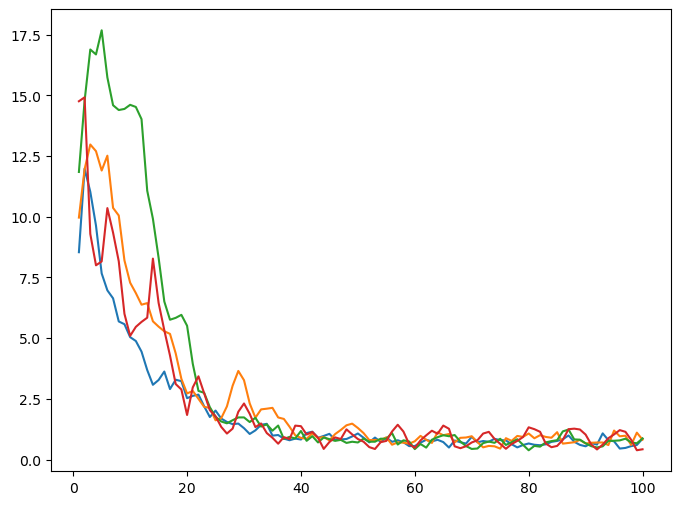

In [126]:
plt.figure(figsize=(8,6))
n_fcst = 3

for w in [1,2,3,4]:
    iw = list(w0s).index(w)
    losses_1 = finalStep_errors[20000][n_fcst][iw]
    plt.plot(np.arange(len(losses_1))+1,losses_1,label=f"w0 = {w}")